# IMDB

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
from fastai import *
from fastai.text import *

# Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [32]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/tmp')]

In [33]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [34]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [35]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [36]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [37]:
data = TextDataBunch.load(path)

# Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

* we need to take care of punctuation
* some words are contractions of two different words, like isn't or don't
* we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [38]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,target
"xxbos xxfld 1 xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come",positive
"xxbos xxfld 1 xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxfld 1 xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos xxfld 1 \n\n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols:

* the "'s" are grouped together in one token
* the contractions are separated like his: "did", "n't"
* content has been cleaned for any HTML symbol and lower cased
* there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

# Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).

In [39]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [40]:
data.train_ds[0][0]

Text xxbos xxfld 1 xxmaj this movie had some xxunk xxunk , but it 's an old story that simply could never happen . xxmaj navy xxunk could never break down that much that a crew much less an xxup xxunk could ever go that far against the xxmaj captain . i 'll take xxmaj dr. xxmaj xxunk any day if i wish to see this plot . xxmaj xxunk -- the xxup us xxmaj navy did not support this film .

In [41]:
data.train_ds[0][0].data[:10]

array([ 2,  3, 45,  4, 20, 26, 79, 62,  0,  0])

# With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.



In [42]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

# Language model

Now let's grab the full dataset for what follows.

In [43]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab')]

In [44]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsup'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos')]

In [45]:
bs=42

In [46]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
#data_lm.save('tmp_lm')

In [47]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj watching this odd little adventure movie , it 's hard to believe that it was directed by the same man who brought us such high quality xxmaj giallo classics as xxmaj the xxmaj strange xxmaj vice of xxmaj mrs xxmaj wardh and xxmaj the xxmaj case of the xxmaj scorpion 's xxmaj tail , but it has to be said that despite it 's low quality production values"
1,"the protagonists themselves too late . \n\n xxmaj across 110th xxmaj street has some pretty non - believable scenes and segments , which are not explained too carefully and seem little unconvincing , but they are very few and are easy to forgive after all the merits and positive things this film gives . xxmaj this film is as classic as xxmaj dirty xxmaj harry and i give this 9"
2,"flick , one of those movies you have to pay attention to . xxbos i do n't know about the xxmaj english version of this movie , but the xxmaj norwegian translation is the funniest movie i 've seen in many years . xxmaj the characters say so many funny things and make so many weird references to current events that i 'm amazed they kept having more options ,"
3,can when xxup rko went under and was sold to xxmaj warner xxmaj brothers to distribute . xxmaj also the fact that it was produced by xxmaj benedict xxmaj xxunk who was a producer of b films of varying quality tells me why it did not get the budget for decent special effects . \n\n xxmaj xxunk was not the guy for this kind of film . xxmaj take a
4,"most notably the scene where the xxmaj ghost of xxmaj christmas xxmaj present takes xxmaj scrooge on a tour of remote areas where even people in seclusion are reveling in the spirit of the day . xxmaj this version does include that part of the book . xxmaj it utilizes the singing of "" xxmaj silent xxmaj night "" as a continuity element from one celebration to another . xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [48]:
type(data_lm)

fastai.text.data.TextLMDataBunch

In [49]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


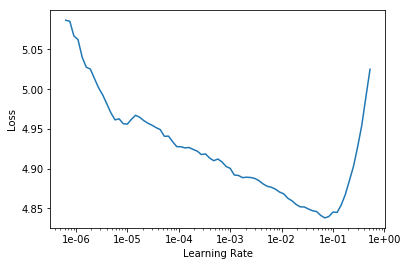

In [51]:
learn.recorder.plot(skip_end=15)

In [52]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.240804,4.093825,0.291392


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

In [53]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.968198,3.931187,0.306460
2,3.925634,3.862437,0.315415
3,3.889155,3.822785,0.321395
4,3.829451,3.789977,0.325515
5,3.766985,3.768007,0.328038
6,3.721386,3.746146,0.330462
7,3.689700,3.731159,0.331895
8,3.681573,3.714367,0.333620


KeyboardInterrupt: 

In [54]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [55]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [56]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

i liked this movie because i liked xxmaj soundtrack of all xxmaj high xxmaj school movies . i beautifully fight the love 1949 and wait ! happier ending xxrep 4 ! premiere then touching circuit ! ! ) i loved the ending feeling sad ,
i liked this movie because it 's vague and creepy . xxmaj but its like high on your eyes and it is not your golden egg you 'll be thinking of . i give this movie a 10 as well in my opinion , xxmaj


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [62]:
learn.save_encoder('fine_tuned_enc')

# Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [57]:
path = untar_data(URLs.IMDB)

In [58]:
path

PosixPath('/root/.fastai/data/imdb')

In [74]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #remove docs with labels not in above list (i.e. 'unsup')
             #label them all with their folders
             .databunch(bs=bs))

In [ ]:
data_clas.save('tmp_clas')

In [ ]:
len(data_clas.train_ds)

In [60]:
#data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj this was the second of two filmed "" xxmaj hamlets "" in the nineties , the first being xxmaj franco xxmaj zeffirelli 's , starring xxmaj mel xxmaj gibson , from 1990 . xxmaj zeffirelli 's version , like xxmaj laurence xxmaj olivier 's from 1948 , was based upon an abridged version of the play , with much of xxmaj shakespeare 's original text being cut .",pos
"xxbos xxmaj johnathan xxmaj frakes is a good actor and , when he 's not directing a family film , a fine director . xxmaj but , he really should n't have directed this movie , and the screenplay should 've been rejected . xxmaj the director and writers must understand what the original xxup tv show was really about , as well as who the characters were and how",neg
"xxbos xxmaj this xxup tv production of 1970 starring xxmaj susannah xxmaj york and xxmaj george xxup c. xxmaj scott is another proof of how difficult it is to adopt "" xxmaj jane xxmaj eyre "" to the screen , and how much can go wrong in doing so . xxmaj it is true that the movie suffered in the transfer to xxup dvd - some scenes which were complete",neg
"xxbos xxmaj unless i 'm sadly mistaken , i rented a xxmaj nightmare on xxmaj elm xxmaj street 3 several years ago and there was a music video , i 'm pretty sure which was called xxmaj dream xxmaj warriors , at the end of it , and i rented this one on xxup dvd hoping that the video would be there because it was one of the funniest things",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [63]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


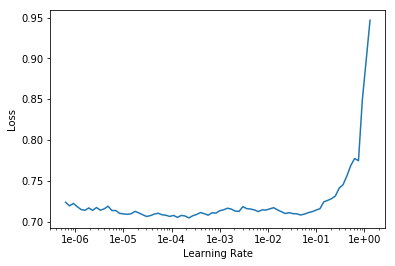

In [65]:
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.692744,0.704047,0.500000


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [67]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [35]:
learn.load('third');

FileNotFoundError: [Errno 2] No such file or directory: '/root/.fastai/data/imdb/models/third.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")